In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

In [2]:
train = pd.read_csv('/home/aistudio/data/data2196/train.csv')
test = pd.read_csv('/home/aistudio/data/data2196/test.csv')
train_data = train

In [3]:
age = train_data[['Age','Survived','Fare','Parch','SibSp','Pclass']]
age_notnull = age.loc[(train_data.Age.notnull())]
age_isnull = age.loc[(train_data.Age.isnull())]
X = age_notnull.values[:,1:]
Y = age_notnull.values[:,0]
rfr = RandomForestRegressor(n_estimators=1000,n_jobs=-1)
rfr.fit(X,Y)
predictAges = rfr.predict(age_isnull.values[:,1:])
train_data.loc[(train_data.Age.isnull()),'Age'] = predictAges

In [4]:
train_data.loc[train_data['Sex'] == 'male', 'Sex'] = 0
train_data.loc[train_data['Sex'] == 'female', 'Sex'] = 1

In [5]:
train_data['Embarked'] = train_data['Embarked'].fillna('S')
train_data.loc[train_data['Embarked'] == 'S', 'Embarked'] = 0
train_data.loc[train_data['Embarked'] == 'C', 'Embarked'] = 1
train_data.loc[train_data['Embarked'] == 'Q', 'Embarked'] = 2

In [6]:
train_data.drop(['Cabin'], axis=1, inplace=True)
train_data['Deceased'] = train_data['Survived'].apply(lambda s: 1 - s)

In [7]:
dataset_X = train_data[['Sex', 'Age', 'Pclass', 'SibSp', 'Parch', 'Fare']]
dataset_Y = train_data[['Deceased', 'Survived']]

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(dataset_X.as_matrix(),
                                                  dataset_Y.as_matrix(),
                                                  test_size=0.2,
                                                  random_state=42)

In [9]:
import paddle.fluid as fluid

In [10]:
dimension = 20
def convolutional_neural_network():
    '''
    Construct a 2 level layers neural network using PaddlePaddle.fluid
    Input: R6 vector
    Output: R2 vector
        Active Function: Relu
        Softmax Cross Entropy
        Adam Optimizer
    '''
    
    # Input layer
    data = fluid.layers.data(
        name='X_train', 
        shape=[6], 
        dtype = 'float32')
    
    # Expected output layer
    label = fluid.layers.data(
        name='Y_train', 
        shape=[2], 
        dtype = 'float32')
    
    # convolutional full connection layer with Relu as active function
    conv_pool_1 = fluid.layers.fc(
        input=data, 
        size=dimension, 
        act="relu")
    
    # Output layer
    predict = fluid.layers.fc(
        input=conv_pool_1, 
        size=2, 
        act=None)
    
    # Predict a cross-entropy loss
    cost = fluid.layers.softmax_with_cross_entropy(logits=predict, label=label, soft_label=True)
    
    avg_cost = fluid.layers.reduce_mean(cost)
    return avg_cost

def optimizer_program():
    learning_rate = 0.001
    # Use AdamOptimizer. Foremost is that it uses moving averages of the parameters (momentum).
    return fluid.optimizer.AdamOptimizer(learning_rate)

In [11]:
place = fluid.CPUPlace()
trainer = fluid.Trainer(
     train_func=convolutional_neural_network,
     place=place,
     optimizer_func=optimizer_program)

In [12]:
feed_order = ['X_train', 'Y_train']

In [13]:
def read_data(x, y):
    def reader():
        for i in range(x.shape[0]):
            yield x[i], y[i]
    return reader

In [14]:
def train():
    global X_train, Y_train
    return read_data(X_train, Y_train)

In [15]:
# Plot data
from paddle.v2.plot import Ploter
train_title = "Train cost"
test_title = "Test cost"
plot_cost = Ploter(train_title, test_title)
params_dirname = "result"

step = 0
# 事件处理
def event_handler_plot(event):
    global step
    if isinstance(event, fluid.EndStepEvent):
        if event.step % 10 == 0:
            plot_cost.append(train_title, step, event.metrics[0])
            plot_cost.plot()

            #if test_metrics[0] < 10.0:
                # 如果准确率达到阈值，则停止训练
               # print('loss is less than 10.0, stop')
                # trainer.stop()
        print event.epoch
        print event.metrics
        
        # 将参数存储，用于预测使用
        if params_dirname is not None:
            trainer.save_params(params_dirname)

    step += 1

In [16]:
# 创建执行器，palce在程序初始化时设定
exe = fluid.Executor(place)
# 初始化执行器
exe.run( fluid.default_startup_program() )

[]

In [17]:
import paddle
# 设置训练reader
train_reader = paddle.batch(
    paddle.reader.shuffle(
        train(), 
        buf_size=500),
    batch_size=20)
test_reader = train_reader

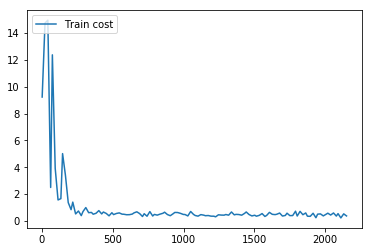

29
[array([0.3708898], dtype=float32)]
29
[array([0.40005678], dtype=float32)]
29
[array([0.6642795], dtype=float32)]
29
[array([0.5396117], dtype=float32)]
29
[array([0.41213807], dtype=float32)]


<Figure size 432x288 with 0 Axes>

In [18]:
trainer.train(
     reader=train_reader,
     num_epochs=30,
     event_handler=event_handler_plot,
     feed_order=feed_order)

In [19]:
trainer.test(reader=test_reader, feed_order=feed_order)

[0.4540038389819009]

In [20]:
# 读测试数据
test_data = test

# 数据清洗, 数据预处理
test_data.loc[test_data['Sex'] == 'male', 'Sex'] = 0
test_data.loc[test_data['Sex'] == 'female', 'Sex'] = 1

age = test_data[['Age', 'Sex', 'Parch', 'SibSp', 'Pclass']]
age_notnull = age.loc[(test_data.Age.notnull())]
age_isnull = age.loc[(test_data.Age.isnull())]
X = age_notnull.values[:, 1:]
Y = age_notnull.values[:, 0]
rfr = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
rfr.fit(X, Y)
predictAges = rfr.predict(age_isnull.values[:, 1:])
test_data.loc[(test_data.Age.isnull()), 'Age'] = predictAges

test_data['Embarked'] = test_data['Embarked'].fillna('S')
test_data.loc[test_data['Embarked'] == 'S', 'Embarked'] = 0
test_data.loc[test_data['Embarked'] == 'C', 'Embarked'] = 1
test_data.loc[test_data['Embarked'] == 'Q', 'Embarked'] = 2

test_data.drop(['Cabin'], axis=1, inplace=True)

# 特征选择
X_test = test_data[['Sex', 'Age', 'Pclass', 'SibSp', 'Parch', 'Fare']]

In [21]:
# 设置预测程序
def inference_program():
    X_test = fluid.layers.data(name='X_test', shape=[6], dtype='float32')
    conv_pool_1 = fluid.layers.fc(input=X_test, size=dimension, act="relu")
    y_predict = fluid.layers.fc(input=conv_pool_1, size=2, act="softmax")
    return y_predict

In [22]:
inferencer = fluid.Inferencer(infer_func=inference_program, param_path=params_dirname, place=place)
results = inferencer.infer({'X_test': X_test})
survival_rate = 0
for i in range(len(results[0])):
    survival = 0 if results[0][i][0] > results[0][i][1] else 1
    survival_rate = survival_rate + survival
    print i+892, results[0][i], survival
print "survival rate: ", 1.0*survival_rate/len(results[0])

892 [0.8913734  0.10862657] 0
893 [0.87182546 0.12817448] 0
894 [0.9537282  0.04627178] 0
895 [0.8414381  0.15856187] 0
896 [0.53375953 0.4662404 ] 0
897 [0.8120996  0.18790036] 0
898 [0.51597047 0.48402953] 0
899 [0.86556864 0.1344314 ] 0
900 [0.3804598 0.6195402] 1
901 [0.9324914  0.06750858] 0
902 [0.8465351  0.15346493] 0
903 [0.70794016 0.29205987] 0
904 [0.19469911 0.80530095] 1
905 [0.8873458  0.11265419] 0
906 [0.17572856 0.82427144] 1
907 [0.29578492 0.70421517] 1
908 [0.79658866 0.2034114 ] 0
909 [0.8146709  0.18532902] 0
910 [0.5242902  0.47570974] 0
911 [0.80980635 0.19019364] 0
912 [0.8629859  0.13701412] 0
913 [0.83591044 0.1640895 ] 0
914 [0.277914 0.722086] 1
915 [0.5409746  0.45902538] 0
916 [0.60963356 0.39036646] 0
917 [0.93790793 0.06209211] 0
918 [0.09284965 0.9071503 ] 1
919 [0.8256525  0.17434748] 0
920 [0.7239     0.27609998] 0
921 [0.92989767 0.07010235] 0
922 [0.8408551  0.15914486] 0
923 [0.85877705 0.14122291] 0
924 [0.6342374  0.36576253] 0
925 [0.3909349  